# Machine Learning Assignment 2
### Elisa Klunder(s5190940), Mihkel Mariusz Jezierski (s4787730), Aksel Joonas Reedi (s4790820)

## Effect of Training Set Size on Model Performance

### Learning Objective
Students will learn about the effect of training set size on the performance of their models.

### Instructions

1. **Choose a Dataset:**
   - Select one of the datasets mentioned below from this [scikit-learn link](https://scikit-learn.org/stable/datasets.html):
     - California housing
     - Olivetti faces
     - Iris
     - Diabetes
     - Digits
     - Linnerrud
   - Ideally, between all student groups, all datasets should be chosen. Your choice does not affect your grade.

2. **Select a Machine Learning Model:**
   - Choose a machine learning model of your choice (the choice does not affect your grade either), but make sure it is appropriate for the task (classification or regression).

3. **Training the Model:**
   - Train the model first on 10% of the training dataset, then on 30%, then on 50%, and finally on the entire training dataset.
   - The smaller training sets can be obtained by sampling the original training set using `numpy.random.choice` (without replacement).
   - Hence, you will train four models in total.
   - Ensure each of your models obtains the best possible performance by tuning hyper-parameters.

4. **Evaluation:**
   - To compare the performance of the models, the final evaluation must be done on the same data across all models.

5. **Plot the Results:**
   - Plot the performance of your four models.
   - Analyze the plot to observe the relationship between evaluation performance and the size of the training set.
   - Write in your own words the observations that you made.

### Deliverables
- A plot showing the performance of models trained on different sizes of the training set.
- A written analysis of the observations made from the plot, discussing the relation between training set size and model performance.

# Solution
We dedcided to use the "Olivetti faces" dataset and to perform classification. We chose to implement a Support Vector Machine as our model, because it is a suitable model to perform classification and it allows us to perform both linear and non-linear classification based on the kernel hyperparameter.

In [ ]:
# Importing the necessary libraries
!pip install scikit-optimize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
import warnings
warnings.filterwarnings('ignore')

In [72]:
# Getting the data
X, y = fetch_olivetti_faces(return_X_y = True, shuffle = True)
n_samples, n_features = X.shape

# Centering the pixel values of the data due to the lighting differences between pictures (normalizing the data)
X_centered = X - X.mean(axis=0)
X_centered -= X_centered.mean(axis=1).reshape(n_samples, -1)

In [88]:
# Split data into 80% train and 20% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_centered, y, test_size=0.2, random_state = 42, stratify = y

)
'''
we set 'stratify' parameter to 'y' to keep the representation of different samples (images of the same person) proportional across the train and test set
'''

"\nwe set 'stratify' parameter to 'y' to keep the representation of different samples (images of the same person) proportional across the train and test set  \n"

In [118]:
# Create a classifier: a support vector classifier
model = svm.SVC()

## General information on hyperparameter tuning

Support Vector Machines have many kinds of hyperparameters. This is how we decided to tune the hyperparameters for all our four models.

We chose to tune:

*   ‘kernel’, because we need to check which of the kernels best reflects the shape of our decision boundaries
*   ‘C’, because this controls the softness of the boundaries
*   ‘decision_function_shape’, because we want to know is a one-vs-one or one-vs-all decision function is more optimal

We chose not to tune:
*   ‘degree’, ‘gamma’, ‘coefficient’ because we ran GridSearchCV with all possible hyperparameter options and the best kernel was linear over 3 runs. These are related to other kernel functions and for runtime efficiency we decided to leave them out.
*   ‘shrinking’, because we saw that after approximately 5 iterations we found our optimal model and we did not need to use an heuristic to optimize runtime.
*   ‘probability’, because printing out the confidence with which a target has been identified is irrelevant to us.
*   ‘tolerance’, we decided to keep it at default value (1*e^-3) because this value is already small enough to obtain a very good performance of our model, and on the other end we don’t need more computational efficiency
*   ‘cache_size’, because we are not concerned with optimizing memory management
*   ‘class_weight’, because all our classes have the same relevance and the same amount of data points
*   ‘verbose’, because we don’t need verbose output
*   ‘max_iter’, because we don’t need more computational efficiency
*   ‘random_state’, because it is related to probability hyperparameter


We will perform grid search to find kernel, decision_function_shape, and the ballpark estimation for C. After that we will perform Bayesian search to finetune the C parameter. \\

**NB: to save time, you don't need to run the grid and bayesian searches for the four models; just run the code blocks where the hyperparameters are manually set based on the results we obtained from the searches**

### First model (10%)

In [125]:
# Sample 10% of the training data
X_train_10_idx = np.random.choice(len(X_train), int(0.10 * len(X_train)), replace = False)
X_train_10, y_train_10 = X_train[X_train_10_idx], y_train[X_train_10_idx]

In [121]:
# Perform grid search cross-validation to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],   # Values of regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'decision_function_shape' : ['ovo','ovr']
}
grid_search = GridSearchCV(model, param_grid, cv=2)  # cv is the number of cross-validation folds

grid_search.fit(X_train_10, y_train_10)
best_params = grid_search.best_params_
model_10 = grid_search.best_params_
print(best_params)

{'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [126]:
# After running the grid search these are the results we got for the parameters
model_10 = svm.SVC(C = 0.1, kernel = 'linear', decision_function_shape = 'ovo')

In [79]:
# Perform Bayesian search cross-validation to further tune the 'C' hyperparameter
from skopt import BayesSearchCV
from skopt import space

param_space = {
    'C': space.Real(0.8*best_params['C'], 1.2*best_params['C']),
    'kernel': space.Categorical([best_params['kernel']]),
    'decision_function_shape': space.Categorical([best_params['decision_function_shape']])
}

opt = BayesSearchCV(
    estimator=model_10,
    search_spaces=param_space,
    n_iter=100,  # Number of optimization iterations
    cv=2,       # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
)

opt.fit(X_train_10, y_train_10)
best_params = opt.best_params_
print(best_params)

OrderedDict([('C', 0.10496860708493899), ('decision_function_shape', 'ovo'), ('kernel', 'linear')])


In [127]:
# After running the Bayesian search these are the results we got for the parameters
model_10 = svm.SVC(C = 0.10496860708493899, kernel = 'linear', decision_function_shape = 'ovo')
model_10.fit(X_train_10, y_train_10)

SVC(C=0.10496860708493899, decision_function_shape='ovo', kernel='linear')

### Second model (30%)

In [97]:
# Sample 30% of the training data
X_train_30_idx = np.random.choice(len(X_train), int(0.30 * len(X_train)), replace = False)
X_train_30, y_train_30 = X_train[X_train_30_idx], y_train[X_train_30_idx]

In [ ]:
# Perform grid search cross-validation to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],   # Values of regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'decision_function_shape' : ['ovo','ovr']
}
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv is the number of cross-validation folds

grid_search.fit(X_train_30, y_train_30)
best_params = grid_search.best_params_
print(best_params)

In [98]:
# After running the grid search these are the results we got for the parameters
model_30 = svm.SVC(C = 0.1, kernel = 'linear', decision_function_shape = 'ovo')

In [ ]:
# Perform Bayesian search cross-validation to further tune the 'C' hyperparameter
from skopt import BayesSearchCV
from skopt import space

param_space = {
    'C': space.Real(0.8*best_params['C'], 1.2*best_params['C']),
    'kernel': space.Categorical([best_params['kernel']]),
    'decision_function_shape': space.Categorical([best_params['decision_function_shape']])
}

opt = BayesSearchCV(
    estimator=model_30,
    search_spaces=param_space,
    n_iter=100,  # Number of optimization iterations
    cv=5,       # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
)

opt.fit(X_train_30, y_train_30)
best_params = opt.best_params_
print(best_params)

In [99]:
# After running the Bayesian search these are the results we got for the parameters
model_30 = svm.SVC(C =  0.11811072825923316, kernel = 'linear', decision_function_shape = 'ovo')
model_30.fit(X_train_30, y_train_30)

SVC(C=0.11811072825923316, decision_function_shape='ovo', kernel='linear')

### Third model (50%)

In [100]:
# Sample 10% of the training data
X_train_50_idx = np.random.choice(len(X_train), int(0.50 * len(X_train)), replace = False)
X_train_50, y_train_50 = X_train[X_train_50_idx], y_train[X_train_50_idx]

In [ ]:
# Perform grid search cross-validation to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],   # Values of regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'decision_function_shape' : ['ovo','ovr']
}
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv is the number of cross-validation folds

grid_search.fit(X_train_50, y_train_50)
best_params = grid_search.best_params_
print(best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear'}


In [101]:
# After running the grid search these are the results we got for the parameters
model_50 = svm.SVC(C = 0.1, kernel = 'linear', decision_function_shape = 'ovo')

In [ ]:
# Perform Bayesian search cross-validation to further tune the 'C' hyperparameter
from skopt import BayesSearchCV
from skopt import space

param_space = {
    'C': space.Real(0.8*best_params['C'], 1.2*best_params['C']),
    'kernel': space.Categorical([best_params['kernel']]),
    'decision_function_shape': space.Categorical([best_params['decision_function_shape']])
}

opt = BayesSearchCV(
    estimator=model_50,
    search_spaces=param_space,
    n_iter=100,  # Number of optimization iterations
    cv=5,       # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
)

opt.fit(X_train_50, y_train_50)
best_params = opt.best_params_
print(best_params)

In [102]:
# After running the Bayesian search these are the results we got for the parameters
model_50 = svm.SVC(C = 0.09961648101192605, kernel = 'linear', decision_function_shape = 'ovo')
model_50.fit(X_train_50, y_train_50)

SVC(C=0.09961648101192605, decision_function_shape='ovo', kernel='linear')

### Fourth model (100% of training data)

In [ ]:
# Perform grid search cross-validation to tune the hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],   # Values of regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'decision_function_shape' : ['ovo','ovr']
}
grid_search = GridSearchCV(model, param_grid, cv=5)  # cv is the number of cross-validation folds

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(best_params)

In [137]:
# After running the grid search these are the results we got for the parameters
model_100 = svm.SVC(C = 0.1, kernel = 'linear', decision_function_shape = 'ovo')

In [ ]:
# Perform Bayesian search cross-validation to further tune the 'C' hyperparameter
from skopt import BayesSearchCV
from skopt import space

param_space = {
    'C': space.Real(0.8*best_params['C'], 1.2*best_params['C']),
    'kernel': space.Categorical([best_params['kernel']]),
    'decision_function_shape': space.Categorical([best_params['decision_function_shape']])
}

opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=100,  # Number of optimization iterations
    cv=5,       # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPU cores
)

opt.fit(X_train, y_train)
best_params = opt.best_params_
print(best_params)

In [141]:
# After running the Bayesian search these are the results we got for the parameters
model_100 = svm.SVC(C = 0.10597011794641167, kernel = 'linear', decision_function_shape = 'ovo')
model_100.fit(X_train, y_train)

SVC(C=0.10597011794641167, decision_function_shape='ovo', kernel='linear')

## Comparing the four different models

We will display the performance of the four models basing ourselves on the accuracy scores. We chose this metric instead of other metrics (e.g. balanced-accuracy or f-scores) because our dataset is perfectly balanced with respect to class weight and class representation. Furthermore we weren't particularly interested in giving more importance to either precision or recall, since in our opinion their respective relevance depends on the specific appilcation that facial recognition is used for, which isn't relevant for us. We think that accuracy, which is just the rate of correctly classified data points, is a good evalution metric for this model. \\

For all four models, we will plot the accuracy scores on the train and test sets. The train sets will differ for every model, while the test set will always be the same. By plotting both train and test scores we hope to spot overfitting and underfitting.

In [128]:
# 10% model

# Training fit scores
y_pred_10_training = model_10.predict(X_train_10)
accuracy_train_10 = metrics.accuracy_score(y_train_10, y_pred_10_training)
print(
    "Train predictions performance\n"
    f"Accuracy {accuracy_train_10}\n"
)

# Test fit scores
y_pred_10 = model_10.predict(X_test)
accuracy_test_10 = metrics.accuracy_score(y_test, y_pred_10)
print(
    "Test predictions performance\n"
    f"Accuracy {accuracy_test_10}\n"
)

Train predictions performance
Accuracy 1.0

Test predictions performance
Accuracy 0.3625



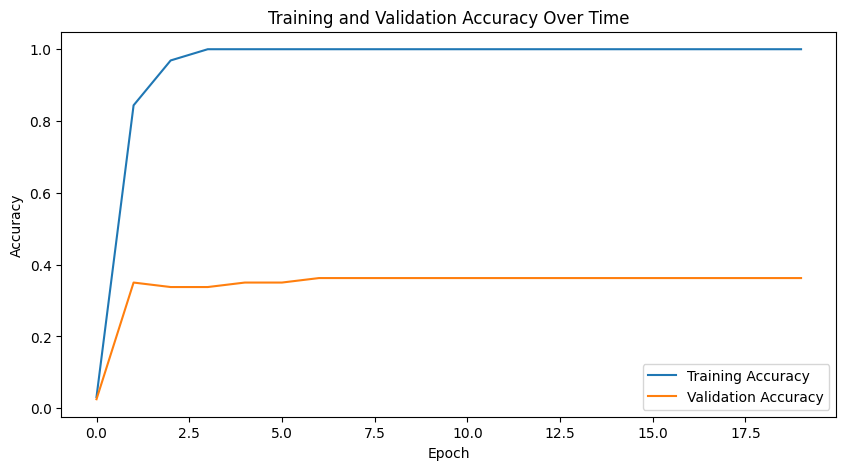

In [130]:
# Plotting training and validation performance
training_array = []
test_array = []
epochs =  range(20)

for i in epochs:
  model = svm.SVC(C = 0.10496860708493899, kernel = 'linear', decision_function_shape = 'ovo', max_iter = i)
  model.fit(X_train_10, y_train_10)
  y_pred_training = model.predict(X_train_10)
  training_array.append(metrics.accuracy_score(y_train_10, y_pred_training))
  y_pred = model.predict(X_test)
  test_array.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_array, label='Training Accuracy')
plt.plot(epochs, test_array, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Time')
plt.show()


In [131]:
# 30% model

# Training fit scores
y_pred_30_training = model_30.predict(X_train_30)
accuracy_train_30 = metrics.accuracy_score(y_train_30, y_pred_30_training)
print(
    "Train predictions performance\n"
    f"Accuracy {accuracy_train_30}\n"
)

# Test fit scores
y_pred_30 = model_30.predict(X_test)
accuracy_test_30 = metrics.accuracy_score(y_test, y_pred_30)
print(
    "Test predictions performance\n"
    f"Accuracy {accuracy_test_30}\n"
)

Train predictions performance
Accuracy 1.0

Test predictions performance
Accuracy 0.725



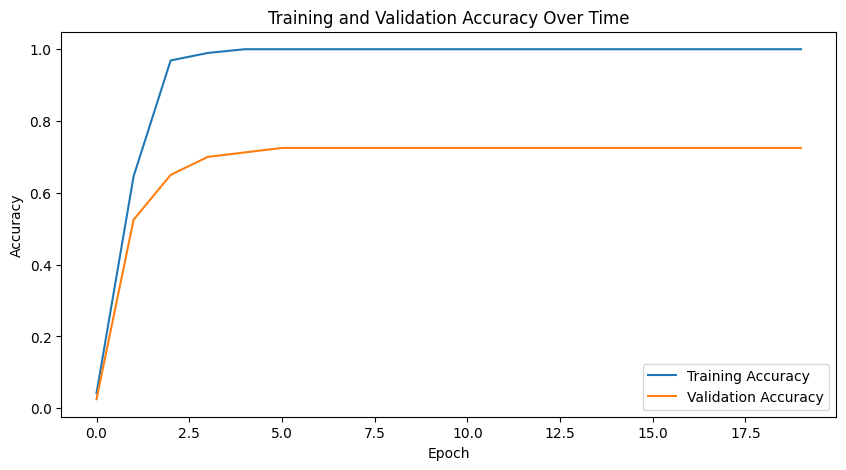

In [132]:
# Plotting training and validation performance
training_array = []
test_array = []
epochs =  range(20)

for i in epochs:
  model = svm.SVC(C =  0.11811072825923316, kernel = 'linear', decision_function_shape = 'ovo', max_iter = i)
  model.fit(X_train_30, y_train_30)
  y_pred_training = model.predict(X_train_30)
  training_array.append(metrics.accuracy_score(y_train_30, y_pred_training))
  y_pred = model.predict(X_test)
  test_array.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_array, label='Training Accuracy')
plt.plot(epochs, test_array, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Time')
plt.show()

In [133]:
# 50% model

# Training fit scores
y_pred_50_training = model_50.predict(X_train_50)
accuracy_train_50 = metrics.accuracy_score(y_train_50, y_pred_50_training)
print(
    "Train predictions performance\n"
    f"Accuracy {accuracy_train_50}\n"
)

# Test fit scores
y_pred_50 = model_50.predict(X_test)
accuracy_test_50 = metrics.accuracy_score(y_test, y_pred_50)
print(
    "Test predictions performance\n"
    f"Accuracy {accuracy_test_50}\n"
)

Train predictions performance
Accuracy 1.0

Test predictions performance
Accuracy 0.825



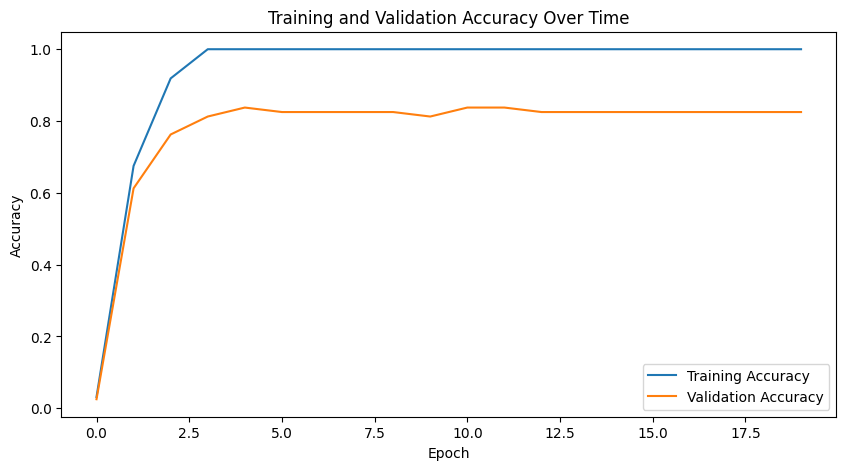

In [134]:
# Plotting training and validation performance
training_array = []
test_array = []
epochs =  range(20)

for i in epochs:
  model = svm.SVC(C = 0.09961648101192605, kernel = 'linear', decision_function_shape = 'ovo', max_iter = i)
  model.fit(X_train_50, y_train_50)
  y_pred_training = model.predict(X_train_50)
  training_array.append(metrics.accuracy_score(y_train_50, y_pred_training))
  y_pred = model.predict(X_test)
  test_array.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_array, label='Training Accuracy')
plt.plot(epochs, test_array, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Time')
plt.show()

In [142]:
# 100% model

# Training fit scores
y_pred_training = model_100.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_training)
print(
    "Train predictions performance\n"
    f"Accuracy {accuracy_train}\n"
)

# Test fit scores
y_pred = model_100.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred)
print(
    "Test predictions performance\n"
    f"Accuracy {accuracy_test}\n"
)

Train predictions performance
Accuracy 1.0

Test predictions performance
Accuracy 0.9625



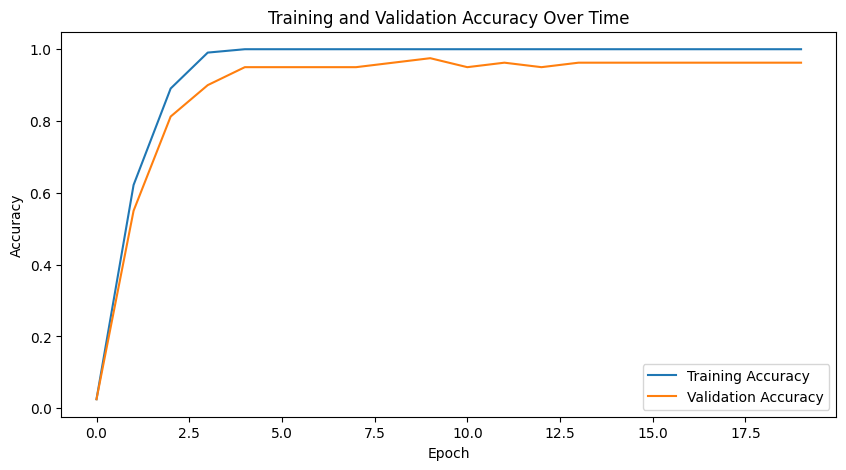

In [143]:
# Plotting training and validation performance
training_array = []
test_array = []
epochs =  range(20)

for i in range(20):
  model = svm.SVC(C = 0.10597011794641167, kernel = 'linear', decision_function_shape = 'ovo', max_iter =i)
  model.fit(X_train, y_train)
  y_pred_training = model.predict(X_train)
  training_array.append(metrics.accuracy_score(y_train, y_pred_training))
  y_pred = model.predict(X_test)
  test_array.append(metrics.accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_array, label='Training Accuracy')
plt.plot(epochs, test_array, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Time')
plt.show()


Instead of showing the learning curves of every model, we can also plot the accuracy scores of each of the models based on the number of samples in the training set. This will clearly show us what we can already deduct: that a bigger training set leads to better accuracy.

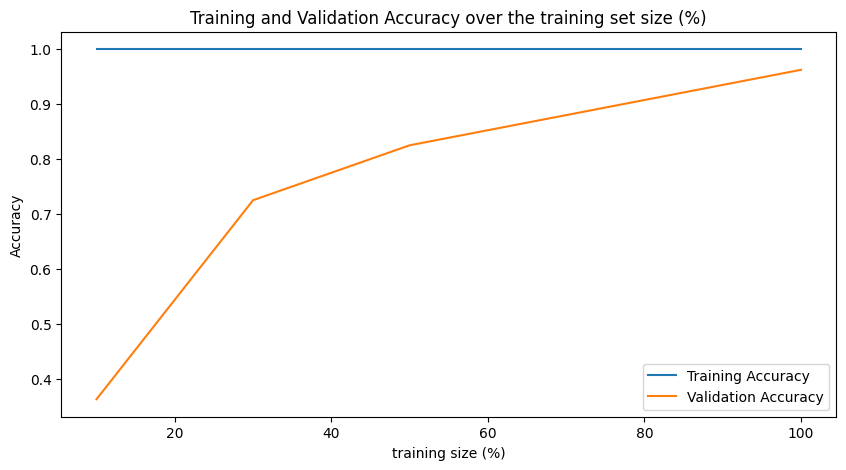

In [144]:
training_sizes = [10, 30, 50, 100]
accuracies_train = [accuracy_train_10, accuracy_train_30, accuracy_train_50, accuracy_train]
accuracies_test = [accuracy_test_10, accuracy_test_30, accuracy_test_50, accuracy_test]

plt.figure(figsize=(10, 5))
plt.plot(training_sizes, accuracies_train, label='Training Accuracy')
plt.plot(training_sizes, accuracies_test, label='Validation Accuracy')
plt.xlabel('training size (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy over the training set size (%)')
plt.show()

Both from the individual plots, and from the last general plot, we can see that with small training set sizes (e.g., 10% and 30%), even after hyperparameter tuning, the model largely overfits. This can be seen form the big gap between training accuracy (much higher) and test accuracy (much lower). As the training set data increases, this gap gets smaller, which is indication of a better model.

## For the fun of it
Finally, and just for fun, we can show a sample of the results of our best model (the fourth) by showing the pictures with their prediction and their actual label.

In [69]:
# Show the predictions
n_row, n_col = 5, 8
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec, target, prediction in zip(axs.flat, images, y_test, y_pred):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")
        ax.set_title(f"Target: {target} \n Prediction: {prediction}")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()


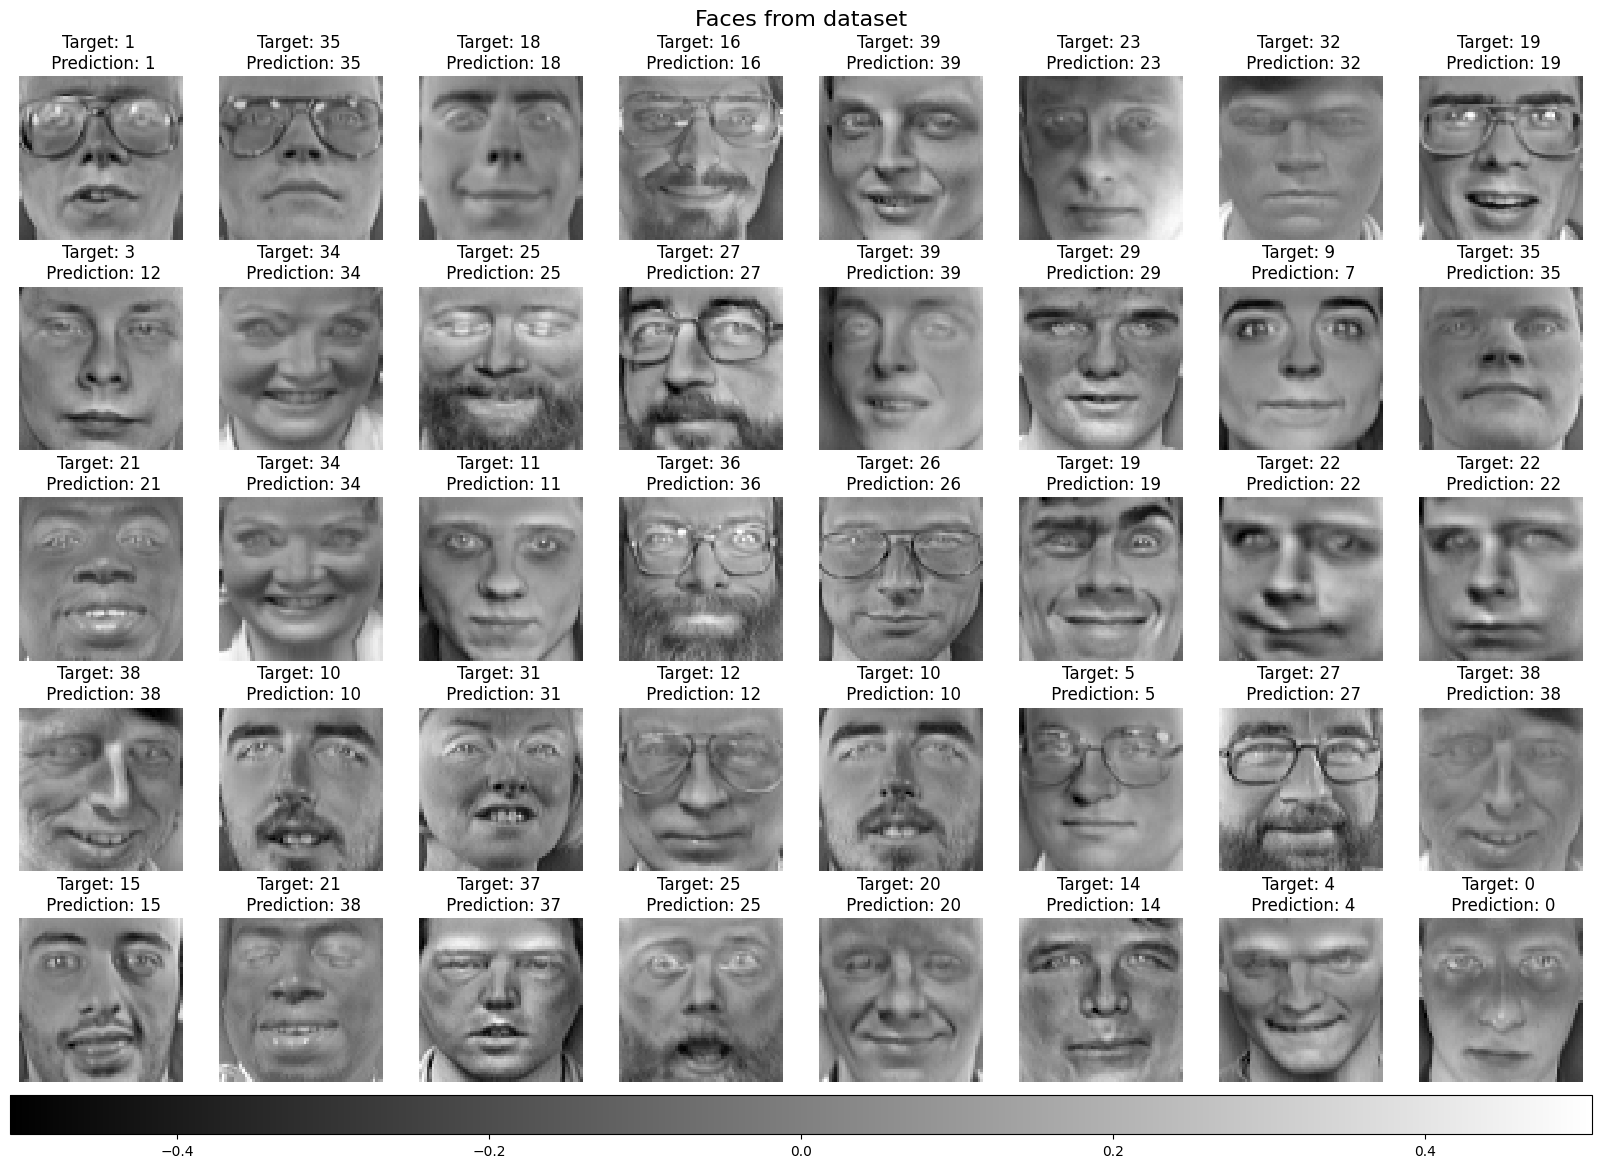

In [70]:
plot_gallery("Faces from dataset", X_test[:n_components])